In [1]:
# SIRYA: metti entrambi a True se sei su colab
COLAB = False
SIRYA = False

if COLAB:

    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    !rm -rf LCTSCProject2024
    !git clone https://github.com/AI-For-Experimental-And-Applied-Physics/LCTSCProject2024.git
    !pip install itkwidgets
    !pip install -r LCTSCProject2024/requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pydicom
import os

from ipywidgets import interact, IntSlider
import itkwidgets as viewer

In [3]:
if SIRYA:
    data_base_dir = '/content/drive/MyDrive/Colab Notebooks/Biomedical Imaging/DATA'
    data_csv = '/content/drive/MyDrive/Colab Notebooks/Biomedical Imaging/DATA/lctsc_metadata.csv'
else:
    data_base_dir = './'
    data_csv = './lctsc_metadata.csv'

## Exploring the Dataset Structure and Metadata

Let's start by exploring the directory structure and reading the metadata from the DICOM files.

In [4]:
# Load the metadata.csv file
metadata_df = pd.read_csv(data_csv)

# Display the first few rows and column information
print(metadata_df.head())
print(metadata_df.info())

                                          Series UID Collection  \
0  1.3.6.1.4.1.14519.5.2.1.7014.4598.280355341349...      LCTSC   
1  1.3.6.1.4.1.14519.5.2.1.7014.4598.110977663386...      LCTSC   
2  1.3.6.1.4.1.14519.5.2.1.7014.4598.106943890850...      LCTSC   
3  1.3.6.1.4.1.14519.5.2.1.7014.4598.578895540487...      LCTSC   
4  1.3.6.1.4.1.14519.5.2.1.7014.4598.941697026234...      LCTSC   

   3rd Party Analysis                           Data Description URI  \
0                 NaN  https://doi.org/10.7937/K9/TCIA.2017.3r3fvz08   
1                 NaN  https://doi.org/10.7937/K9/TCIA.2017.3r3fvz08   
2                 NaN  https://doi.org/10.7937/K9/TCIA.2017.3r3fvz08   
3                 NaN  https://doi.org/10.7937/K9/TCIA.2017.3r3fvz08   
4                 NaN  https://doi.org/10.7937/K9/TCIA.2017.3r3fvz08   

          Subject ID                                          Study UID  \
0  LCTSC-Test-S1-101  1.3.6.1.4.1.14519.5.2.1.7014.4598.492964872630...   
1  LCTSC-Test-

In [5]:
# fill the patient dict variable
patient_dict = {}

# Method 2: Using itertuples() (More efficient than iterrows())
for row in metadata_df.itertuples():
  patient_id = getattr(row, '_5') # unique Name
  file_type = getattr(row, 'Modality') # check if RTSTRUCT or CT
  file_location = getattr(row, '_16') # Path to the images
  if patient_id in patient_dict.keys() :
    patient_dict[patient_id][file_type] = file_location
  else:
    patient_dict[patient_id] = {}
    patient_dict[patient_id][file_type] = file_location

print(patient_dict)

{'LCTSC-Test-S1-101': {'RTSTRUCT': './LCTSC/LCTSC-Test-S1-101/1.3.6.1.4.1.14519.5.2.1.7014.4598.492964872630309412859177308186/1.3.6.1.4.1.14519.5.2.1.7014.4598.280355341349691222365783556597', 'CT': './LCTSC/LCTSC-Test-S1-101/1.3.6.1.4.1.14519.5.2.1.7014.4598.492964872630309412859177308186/1.3.6.1.4.1.14519.5.2.1.7014.4598.106943890850011666503487579262'}, 'LCTSC-Test-S1-102': {'RTSTRUCT': './LCTSC/LCTSC-Test-S1-102/1.3.6.1.4.1.14519.5.2.1.7014.4598.238478060677653494401819620444/1.3.6.1.4.1.14519.5.2.1.7014.4598.110977663386843546355807661874', 'CT': './LCTSC/LCTSC-Test-S1-102/1.3.6.1.4.1.14519.5.2.1.7014.4598.238478060677653494401819620444/1.3.6.1.4.1.14519.5.2.1.7014.4598.639871532605224417554459681163'}, 'LCTSC-Test-S1-103': {'CT': './LCTSC/LCTSC-Test-S1-103/1.3.6.1.4.1.14519.5.2.1.7014.4598.816327386653410772475068003264/1.3.6.1.4.1.14519.5.2.1.7014.4598.578895540487402949445746417374', 'RTSTRUCT': './LCTSC/LCTSC-Test-S1-103/1.3.6.1.4.1.14519.5.2.1.7014.4598.816327386653410772475

In [6]:
def load_patient_dicom_files(patient_dir):
    """Loads all DICOM files from a patient directory."""
    dicom_files = []
    for filename in os.listdir(patient_dir):
        if filename.endswith('.dcm'):
            file_path = os.path.join(patient_dir, filename)
            try:
                dicom_files.append(pydicom.dcmread(file_path))
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    return dicom_files

def get_patient_metadata(dicom_files):
    """Extracts relevant metadata from a list of DICOM files for a patient."""
    if not dicom_files:
        return None
    metadata = {
        'PatientID': dicom_files[0].PatientID if 'PatientID' in dicom_files[0] else None,
        'PatientSex': dicom_files[0].PatientSex if 'PatientSex' in dicom_files[0] else None,
        'PatientAge': dicom_files[0].PatientAge if 'PatientAge' in dicom_files[0] else None,
        'StudyDate': dicom_files[0].StudyDate if 'StudyDate' in dicom_files[0] else None,
        'SeriesDescription': dicom_files[0].SeriesDescription if 'SeriesDescription' in dicom_files[0] else None,
        'NumberOfSlices': len(dicom_files),
        # Add more relevant metadata as needed
    }
    return metadata

# Iterate through the patient directories and collect metadata
all_metadata = []

for k,v in patient_dict.items():
  if v['CT']:
    dicom_files = load_patient_dicom_files(os.path.join(data_base_dir,v['CT'].replace('./','')))
    if dicom_files:
        print(f"Patient ID: {k}, Number of DICOM files: {len(dicom_files)}")
        metadata = get_patient_metadata(dicom_files)
        all_metadata.append(metadata)

# Create a Pandas DataFrame from the collected metadata
metadata_df = pd.DataFrame(all_metadata)

# Display the first few rows of the metadata DataFrame
print("First few rows of the metadata DataFrame:")
print(metadata_df.head())

# Basic statistics of the metadata
print("\nBasic statistics of the metadata:")
print(metadata_df.describe(include='all'))



Patient ID: LCTSC-Test-S1-101, Number of DICOM files: 130
Patient ID: LCTSC-Test-S1-102, Number of DICOM files: 148
Patient ID: LCTSC-Test-S1-103, Number of DICOM files: 152
Patient ID: LCTSC-Test-S1-104, Number of DICOM files: 131
Patient ID: LCTSC-Test-S1-201, Number of DICOM files: 117
Patient ID: LCTSC-Test-S1-202, Number of DICOM files: 131
Patient ID: LCTSC-Test-S1-203, Number of DICOM files: 153
Patient ID: LCTSC-Test-S1-204, Number of DICOM files: 138
Patient ID: LCTSC-Test-S2-101, Number of DICOM files: 160
Patient ID: LCTSC-Test-S2-102, Number of DICOM files: 176
Patient ID: LCTSC-Test-S2-103, Number of DICOM files: 120
Patient ID: LCTSC-Test-S2-104, Number of DICOM files: 144
Patient ID: LCTSC-Test-S2-201, Number of DICOM files: 136
Patient ID: LCTSC-Test-S2-202, Number of DICOM files: 142
Patient ID: LCTSC-Test-S2-203, Number of DICOM files: 136
Patient ID: LCTSC-Test-S2-204, Number of DICOM files: 176
Patient ID: LCTSC-Test-S3-101, Number of DICOM files: 199
Patient ID: LC

## Visualizing Individual CT Slices

Let's visualize individual slices from a CT scan.

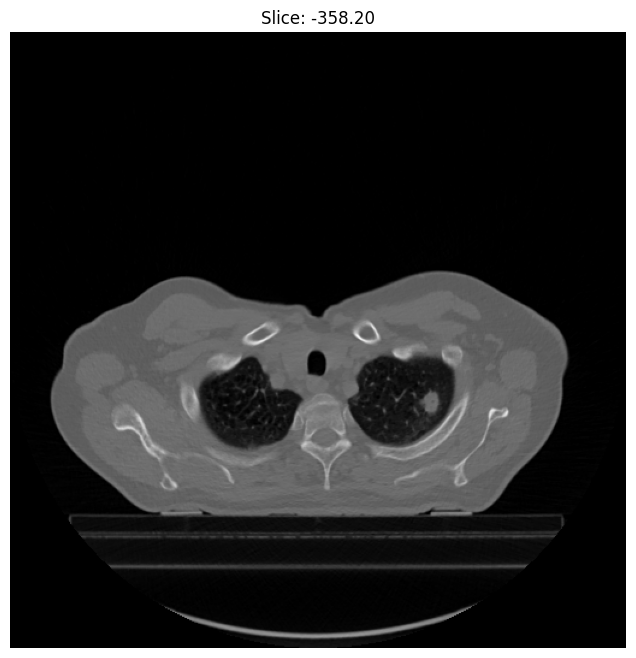

In [7]:
def display_slice(dicom_file):
    """Displays a single CT scan slice."""
    plt.figure(figsize=(8, 8))
    plt.imshow(dicom_file.pixel_array, cmap=plt.cm.gray)
    plt.title(f"Slice: {dicom_file.ImagePositionPatient[2]:.2f}")
    plt.xlabel("Pixels")
    plt.ylabel("Pixels")
    plt.axis('off')
    plt.show()

# Example: Load and display a slice from the first patient
first_key = next(iter(patient_dict))
first_value = patient_dict[first_key]

if first_value['CT']:
  first_patient_files = load_patient_dicom_files(os.path.join(data_base_dir,first_value['CT'].replace('./','')))
  if first_patient_files:
      display_slice(first_patient_files[len(first_patient_files) // 2]) # Display the middle slice


In [8]:
# Interactive slice viewer
def interactive_slice_viewer(dicom_files):
    """Interactive viewer for browsing through CT scan slices."""
    slices = [dcm.pixel_array for dcm in dicom_files]
    def show_slice(slice_num):
        plt.figure(figsize=(8, 8))
        plt.imshow(slices[slice_num], cmap=plt.cm.gray)
        plt.title(f"Slice: {slice_num}")
        plt.xlabel("Pixels")
        plt.ylabel("Pixels")
        plt.axis('off')
        plt.show()

    interact(show_slice, slice_num=IntSlider(min=0, max=len(slices) - 1, step=1, description='Slice Number'))

# Example: Interactive slice viewing for the first patient
first_key = next(iter(patient_dict))
first_value = patient_dict[first_key]

if first_value['CT']:
  first_patient_files = load_patient_dicom_files(os.path.join(data_base_dir,first_value['CT'].replace('./','')))
  if first_patient_files:
      interactive_slice_viewer(first_patient_files)


interactive(children=(IntSlider(value=0, description='Slice Number', max=129), Output()), _dom_classes=('widge…

## Statistical Analysis of the Dataset

Now, let's perform some statistical analysis on the metadata we collected.

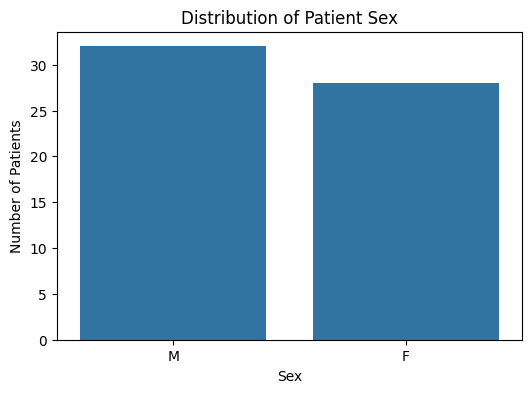

In [9]:
# Distribution of Patient Sex
if 'PatientSex' in metadata_df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=metadata_df, x='PatientSex')
    plt.title('Distribution of Patient Sex')
    plt.xlabel('Sex')
    plt.ylabel('Number of Patients')
    plt.show()

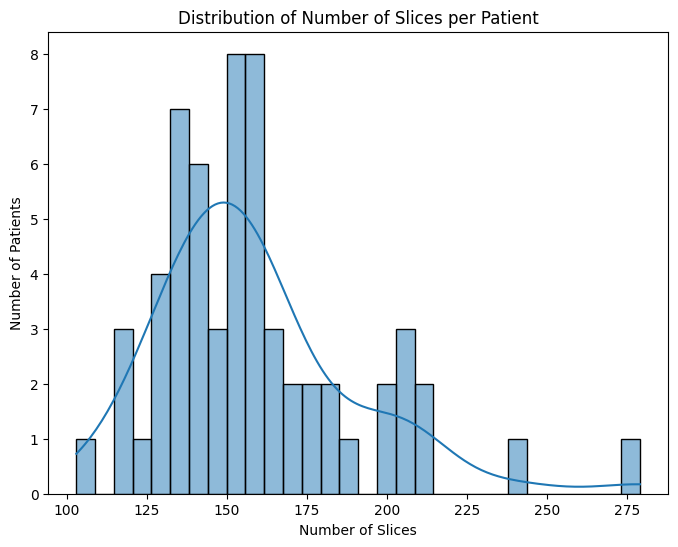

In [10]:
# Distribution of Number of Slices per Patient
if 'NumberOfSlices' in metadata_df.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(metadata_df['NumberOfSlices'], bins=30, kde=True)
    plt.title('Distribution of Number of Slices per Patient')
    plt.xlabel('Number of Slices')
    plt.ylabel('Number of Patients')
    plt.show()

# Preprocessing

In [11]:
import sys
from pathlib import Path

# Add the LCTSCProject2024 parent directory to the Python path
sys.path.append("LCTSCProject2024/")

import pandas as pd
from lctsc_preprocessor.dicom_utils import load_ct_series
from pathlib import Path
from lctsc_preprocessor.rtstruct_utils import load_rtstruct

OUTPUT_DIR = Path('./data_processed')

import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib.colors import ListedColormap
import scipy.ndimage as ndimage

In [12]:
def resize_img(image, dim: int):

  n_slices = image.shape[2]
  resized = np.zeros((dim, dim, n_slices), dtype=image.dtype)

  for i in range(n_slices):
      resized[:, :, i] = cv2.resize(image[:, :, i], (dim, dim), interpolation=cv2.INTER_AREA)

  return resized

In [13]:
def hu_windowing(image: np.ndarray, window_min = -1000, window_max = 400):
    '''
    Apply a Hounsfield Units (HU) windowing to an image.
    '''

    windowed_image = np.clip(image, window_min, window_max)

    return windowed_image

In [20]:
def zoom_on_lungs(image: np.ndarray):

    win_image = hu_windowing(image)

    x = y = w = h = None

    for i in range(win_image.shape[2]):

        slice_img = win_image[:, :, i].astype(np.uint8)
        size = slice_img.shape[0]

        gx = cv2.Sobel(slice_img, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(slice_img, cv2.CV_32F, 0, 1, ksize=3)
        mag = cv2.magnitude(gx, gy)
        mag = cv2.normalize(mag, None, 0, size - 1, cv2.NORM_MINMAX).astype(np.uint8)

        _, thresh = cv2.threshold(mag, 120, size - 1, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            continue

        c = max(contours, key=cv2.contourArea)
        newx, newy, neww, newh = cv2.boundingRect(c)

        # first box
        if x is None:
            x, y, w, h = newx, newy, neww, newh
            continue

        # update only when strictly larger
        if neww * newh > w * h:
            x, y, w, h = newx, newy, neww, newh

    # no box found
    if x is None:
        print("Error! Could not find a bounding box")
        return None

    # pad crop
    img_size = win_image.shape[0]
    pad = int(img_size * 0.07)
    x_pad = max(0, x - pad)
    y_pad = max(0, y - pad)
    w_pad = min(win_image.shape[1] - x_pad, w + 2 * pad)
    h_pad = min(win_image.shape[0] - y_pad, h + 2 * pad)

    crop = win_image[y_pad:y_pad + h_pad, x_pad:x_pad + w_pad, :]

    resized_image = resize_img(crop, 128)
    norm_crop = resized_image - np.min(resized_image)
    norm_crop = norm_crop / np.max(norm_crop)
    return norm_crop, x_pad, y_pad, w_pad, h_pad

In [ ]:
def preprocess_case(case_id: str, ct_path: str, rtstruct_path: str, w_min: int, w_max: int, plot=False):
    ct_dir = Path(ct_path)
    rt_file = Path(rtstruct_path)

    if not ct_dir.exists() or not rt_file.exists():
        print(f"[!] Skipping {case_id}: CT or RTSTRUCT path missing.")
        return

    try:
        image, pixel_dim = load_ct_series(ct_dir)

        print(f'Original image shape: {image.shape}')
        print(f'Original pixel dimensions: {pixel_dim}')

        rtstruct = load_rtstruct(rt_file, ct_dir)
        roi_names = rtstruct.get_roi_names()

        final_img, x, y, w, h = zoom_on_lungs(image)

        print(f'Cropped image shape: {final_img.shape}')

        mask_dict = {}
        for roi in roi_names:
            try:
                mask_raw = rtstruct.get_roi_mask_by_name(roi).astype(np.uint8)
                # Crop the mask using the same coordinates as the image
                mask_cropped = mask_raw[y:y+h, x:x+w]
                # Resize the cropped mask to match the final image size (128x128)
                mask_resized = resize_img(mask_cropped, 128)
                mask_dict[roi] = mask_resized
            except Exception as e:
                print(f"[!] Could not extract ROI '{roi}' for {case_id}: {e}")

        if mask_dict:
            if case_id.find('Train') != -1:
                dir = OUTPUT_DIR / 'Train'
            else:
                dir = OUTPUT_DIR / 'Test'
            dir.mkdir(parents=True, exist_ok=True)
            np.savez_compressed(
                dir / f"{case_id}.npz",
                image=final_img,
                pixel_dim=pixel_dim,
                **mask_dict
            )
            print(f"[✓] Saved {case_id} with {len(mask_dict)} ROIs.")

        else:
            print(f"[!] No valid ROIs found for {case_id}.")
        if plot:
            plot_roi_overlays(final_img, list(mask_dict.values()), list(mask_dict.keys()), pixel_dim)
    except Exception as e:
        print(f"[!] Error processing {case_id}: {e}")

    return x, y, w, h

def plot_roi_overlays(image, masks, roi_names, pixel_dim=[1,1,1]):
    print(pixel_dim)
    # Define colors for ROIs
    colors = plt.colormaps.get_cmap('tab10')
    alpha = 0.25  # Transparency for the overlays

    # Create a combined mask for each ROI
    combined_masks = np.zeros_like(image, dtype=np.float32)
    for i, mask in enumerate(masks):
        combined_masks += mask * (i + 1)

    # Create a custom colormap for the ROIs
    cmap = ListedColormap([colors(i) for i in range(len(roi_names)+1)])

    # Plot on all three planes
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    planes = ['Coronal', 'Axial', 'Sagittal']

    # Coronal plane
    mid_coronal = image.shape[0] // 2
    axes[0].imshow(image[mid_coronal], cmap='gray', aspect=pixel_dim[1] / pixel_dim[2])
    axes[0].imshow(combined_masks[mid_coronal], cmap=cmap, alpha=alpha, aspect=pixel_dim[1] / pixel_dim[2],vmin=0,vmax=len(roi_names)+1)
    axes[0].set_title(f"{planes[0]} Plane")
    axes[0].axis('off')

    # Axial plane
    mid_axial = image.shape[2] // 2
    axes[1].imshow(image[:, :, mid_axial], cmap='gray', aspect=pixel_dim[0] / pixel_dim[1])
    axes[1].imshow(combined_masks[:, :, mid_axial], cmap=cmap, alpha=alpha, aspect=pixel_dim[0] / pixel_dim[1],vmin=0,vmax=len(roi_names)+1)
    axes[1].set_title(f"{planes[1]} Plane")
    axes[1].axis('off')

    # Sagittal plane
    mid_sagittal = image.shape[1] // 2
    axes[2].imshow(image[:, mid_sagittal, :], cmap='gray', aspect=pixel_dim[0] / pixel_dim[2])
    axes[2].imshow(combined_masks[:, mid_sagittal, :], cmap=cmap, alpha=alpha, aspect=pixel_dim[0] / pixel_dim[2],vmin=0,vmax=len(roi_names)+1)
    axes[2].set_title(f"{planes[2]} Plane")
    axes[2].axis('off')

    # Add a legend for ROI names
    handles = [plt.Line2D([0], [0], color=colors(i+1), lw=4) for i in range(len(roi_names))]
    fig.legend(handles, roi_names, loc='upper center', ncol=len(roi_names), bbox_to_anchor=(0.5, 0.95))

    plt.tight_layout()
    plt.show()


In [22]:
coor_dict = {}

for k,v in patient_dict.items():
    print(Path(data_base_dir).joinpath(v["CT"]))
    x, y, w, h = preprocess_case(
        case_id = k,
        ct_path = Path(data_base_dir).joinpath(v["CT"]),
        rtstruct_path = Path(data_base_dir).joinpath(v["RTSTRUCT"]).joinpath('1-1.dcm'),
        w_min = -500,
        w_max = 1000,
        plot=False
    )
    coor_dict[k] = (x, y, w, h)
    print(coor_dict)

LCTSC/LCTSC-Test-S1-101/1.3.6.1.4.1.14519.5.2.1.7014.4598.492964872630309412859177308186/1.3.6.1.4.1.14519.5.2.1.7014.4598.106943890850011666503487579262
Original image shape: (512, 512, 130)
Original pixel dimensions: (0.976562, 0.976562, 3.0)
Cropped image shape: (128, 128, 130)
[✓] Saved LCTSC-Test-S1-101 with 5 ROIs.
{'LCTSC-Test-S1-101': (59, 143, 402, 297)}
LCTSC/LCTSC-Test-S1-102/1.3.6.1.4.1.14519.5.2.1.7014.4598.238478060677653494401819620444/1.3.6.1.4.1.14519.5.2.1.7014.4598.639871532605224417554459681163
Original image shape: (512, 512, 148)
Original pixel dimensions: (0.9765625, 0.9765625, 3.0)
Cropped image shape: (128, 128, 148)
[✓] Saved LCTSC-Test-S1-102 with 5 ROIs.
{'LCTSC-Test-S1-101': (59, 143, 402, 297), 'LCTSC-Test-S1-102': (29, 104, 440, 302)}
LCTSC/LCTSC-Test-S1-103/1.3.6.1.4.1.14519.5.2.1.7014.4598.816327386653410772475068003264/1.3.6.1.4.1.14519.5.2.1.7014.4598.578895540487402949445746417374
Original image shape: (512, 512, 152)
Original pixel dimensions: (0.97

In [23]:
# Visualize a preprocessed case
data = np.load(OUTPUT_DIR / "Train" / "LCTSC-Train-S1-001.npz")
image = data['image']
mask_rlung = data['Lung_R']
mask_llung = data['Lung_L']


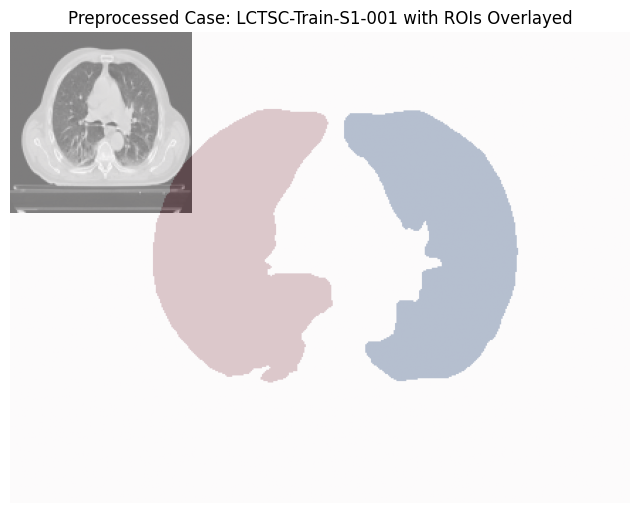

In [24]:
plt.figure(figsize=(8, 8))
plt.imshow(image[:, :, image.shape[2] // 2], cmap='gray')
plt.imshow(mask_rlung[:, :, image.shape[2] // 2], cmap='Reds', alpha=0.3)
plt.imshow(mask_llung[:, :, image.shape[2] // 2], cmap='Blues', alpha=0.3)
plt.title(f"Preprocessed Case: LCTSC-Train-S1-001 with ROIs Overlayed")
plt.axis('off')
plt.show()

In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import time # To time epochs
from tqdm import tqdm # For progress bars

In [26]:
import torch
import gc

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print(f"GPU memory cleared. Available: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

GPU memory cleared. Available: 8.00 GB


In [27]:
class LCTSC_Dataset(Dataset):
    def __init__(self, data_dir, image_transform=None, mask_transform=None):
        self.data_dir = data_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.slices = []
        
        # Create list of (file_path, slice_idx) for each slice in each volume
        for file_name in sorted(os.listdir(data_dir)):
            if file_name.endswith('.npz'):
                file_path = os.path.join(data_dir, file_name)
                data = np.load(file_path)
                num_slices = data['image'].shape[2]
                for slice_idx in range(num_slices):
                    self.slices.append((file_path, slice_idx))

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        file_path, slice_idx = self.slices[idx]
        data = np.load(file_path)
        
        # Get single slice
        image = data['image'][:, :, slice_idx]
        mask_r = data['Lung_R'][:, :, slice_idx].astype(np.float32)
        mask_l = data['Lung_L'][:, :, slice_idx].astype(np.float32)
        mask = np.maximum(mask_r, mask_l).astype(np.float32)

        # Apply separate transforms
        if self.image_transform:
            image = self.image_transform(image=image)['image']
        else:
            image = torch.from_numpy(image).float()
            
        if self.mask_transform:
            mask = self.mask_transform(image=mask)['image']
        else:
            mask = torch.from_numpy(mask).float()
        
        # Ensure channel dimension: (1, H, W)
        if image.dim() == 2:
            image = image.unsqueeze(0)
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)
        
        # Standardize dtype to float32 to avoid mixed precision issues
        image = image.float()
        mask = mask.float()

        return image, mask

In [29]:
TRAIN_IMAGE_DIR = OUTPUT_DIR / 'Train'
VAL_IMAGE_DIR = OUTPUT_DIR / 'Test'

batch_size = 32
train_dataset = LCTSC_Dataset(data_dir=TRAIN_IMAGE_DIR)
val_dataset = LCTSC_Dataset(data_dir=VAL_IMAGE_DIR)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

print(f"Train dataset: {len(train_dataset)} slices")
print(f"Val dataset: {len(val_dataset)} slices")

if train_loader:
    print("\nChecking one batch from train_loader...")
    try:
        images, masks = next(iter(train_loader))
        print(f"Image batch shape: {images.shape}, range: [{images.min():.3f}, {images.max():.3f}]")
        print(f"Mask batch shape: {masks.shape}, range: [{masks.min():.3f}, {masks.max():.3f}]")
        print("Successfully loaded one batch from train_loader.")
    except Exception as e:
        print(f"Error loading batch from train_loader: {e}")


if val_loader:
    print("\nChecking one batch from val_loader...")
    try:
        images, masks = next(iter(val_loader))
        print(f"Image batch shape: {images.shape}, range: [{images.min():.3f}, {images.max():.3f}]")
        print(f"Mask batch shape: {masks.shape}, range: [{masks.min():.3f}, {masks.max():.3f}]")
        print("Successfully loaded one batch from val_loader.")
    except Exception as e:
        print(f"Error loading batch from val_loader: {e}")

Train dataset: 5858 slices
Val dataset: 3675 slices

Checking one batch from train_loader...
Error loading batch from train_loader: stack expects each tensor to be equal size, but got [1, 210, 512] at entry 0 and [1, 351, 465] at entry 1

Checking one batch from val_loader...
Image batch shape: torch.Size([32, 1, 128, 128]), range: [0.000, 1.000]
Mask batch shape: torch.Size([32, 1, 297, 402]), range: [0.000, 1.000]
Successfully loaded one batch from val_loader.


In [30]:
import segmentation_models_pytorch as smp
model = smp.UnetPlusPlus(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     
    in_channels=1,                  # model input channels (1 for grayscale)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [31]:
# Training loop with pytorch

loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs * len(train_loader))

In [32]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.to(device)
    model.train()
    running_loss = 0.0
    batch_losses = []
    
    pbar = tqdm(dataloader, desc="Training", leave=True)
    for batch_idx, (images, masks) in enumerate(pbar):
        images = images.to(device)
        masks = masks.to(device)
        
        # Ensure consistent dtype before autocast
        images = images.float()
        masks = masks.float()
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = loss_fn(outputs, masks)
        
        loss.backward()
        
        # Log gradient statistics
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        lr_scheduler.step()
        
        running_loss += loss.item() * images.size(0)
        batch_losses.append(loss.item())
        
        # Update progress bar with current metrics
        avg_loss = sum(batch_losses) / len(batch_losses)
        pbar.set_postfix({
            'batch_loss': f'{loss.item():.6f}',
            'avg_loss': f'{avg_loss:.6f}',
            'grad_norm': f'{grad_norm:.4f}',
            'out_range': f'[{outputs.min():.2f}, {outputs.max():.2f}]'
        })
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss, batch_losses

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB" if torch.cuda.is_available() else "CPU device")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

model.to(device)

# Count model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel: UNet++ with ResNet34 encoder")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Loss function: Dice Loss (Binary mode)")
print(f"Optimizer: Adam (lr=1e-4)")
print(f"Batch size: {batch_size} slices")
print(f"Training samples: {len(train_dataset)} slices from {len(train_dataset) // 180:.0f} volumes")
print(f"Validation samples: {len(val_dataset)} slices")
print()

# Test first batch to debug
print("="*80)
print("Testing first batch...")
print("="*80)
test_images, test_masks = next(iter(train_loader))
test_images = test_images.to(device).float()
test_masks = test_masks.to(device).float()

with torch.cuda.amp.autocast():
    test_outputs = model(test_images)
    test_loss = loss_fn(test_outputs, test_masks)

print(f"Input shape: {test_images.shape}")
print(f"Input range: [{test_images.min():.3f}, {test_images.max():.3f}]")
print(f"\nMask shape: {test_masks.shape}")
print(f"Mask range: [{test_masks.min():.3f}, {test_masks.max():.3f}]")
print(f"Mask positive pixels: {(test_masks > 0.5).sum().item()} / {test_masks.numel()} ({100 * (test_masks > 0.5).sum().item() / test_masks.numel():.2f}%)")
print(f"\nOutput shape: {test_outputs.shape}")
print(f"Output range: [{test_outputs.min():.3f}, {test_outputs.max():.3f}]")
print(f"Output mean: {test_outputs.mean():.3f}")
print(f"\nTest loss: {test_loss.item():.6f}")
print("="*80)
print()

# Training loop
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"{'='*80}")
    
    start_time = time.time()
    
    # Training
    print("\n[TRAINING]")
    train_loss, batch_losses = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    train_losses.append(train_loss)
    
    print(f"Epoch train loss: {train_loss:.6f}")
    print(f"Batch losses - Min: {min(batch_losses):.6f}, Max: {max(batch_losses):.6f}, Mean: {sum(batch_losses)/len(batch_losses):.6f}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Validation
    print("\n[VALIDATION]")
    model.eval()
    running_vloss = 0.0
    val_batch_losses = []
    
    with torch.no_grad():
        for vimages, vmasks in tqdm(val_loader, desc="Validating", leave=True):
            vimages = vimages.to(device).float()
            vmasks = vmasks.to(device).float()
            
            with torch.cuda.amp.autocast():
                voutputs = model(vimages)
                vloss = loss_fn(voutputs, vmasks)
            
            running_vloss += vloss.item() * vimages.size(0)
            val_batch_losses.append(vloss.item())
    
    epoch_vloss = running_vloss / len(val_loader.dataset)
    val_losses.append(epoch_vloss)
    
    print(f"Epoch val loss: {epoch_vloss:.6f}")
    print(f"Batch losses - Min: {min(val_batch_losses):.6f}, Max: {max(val_batch_losses):.6f}, Mean: {sum(val_batch_losses)/len(val_batch_losses):.6f}")
    
    # Track best model
    if epoch_vloss < best_val_loss:
        best_val_loss = epoch_vloss
        print(f"✓ Best validation loss! Saving checkpoint...")
    
    end_time = time.time()
    epoch_time = end_time - start_time
    
    # Summary
    print(f"\n[SUMMARY]")
    print(f"Train Loss: {train_loss:.6f} | Val Loss: {epoch_vloss:.6f} | Time: {epoch_time:.2f}s")
    print(f"Loss improvement: {((train_losses[0] - train_loss) / train_losses[0] * 100) if epoch > 0 else 0:.2f}%")
    
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(device) / 1024**3
        reserved = torch.cuda.memory_reserved(device) / 1024**3
        print(f"GPU Memory - Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")
    
    torch.cuda.empty_cache()

print(f"\n{'='*80}")
print("Training completed!")
print(f"Final train loss: {train_losses[-1]:.6f}")
print(f"Final val loss: {val_losses[-1]:.6f}")
print(f"Best val loss: {best_val_loss:.6f}")
print(f"{'='*80}")

Using device: cuda
Device: NVIDIA GeForce RTX 3070
Total GPU memory: 8.00 GB

Model: UNet++ with ResNet34 encoder
Total parameters: 15,964,177
Trainable parameters: 15,964,177
Loss function: Dice Loss (Binary mode)
Optimizer: Adam (lr=1e-4)
Batch size: 32 slices
Training samples: 5858 slices from 32 volumes
Validation samples: 3675 slices

Testing first batch...


KeyboardInterrupt: 

In [ ]:
# Save the trained model
model_save_path = './unet_plus_plus_resnet18_lctsc.pth'
model.save_pretrained(model_save_path)

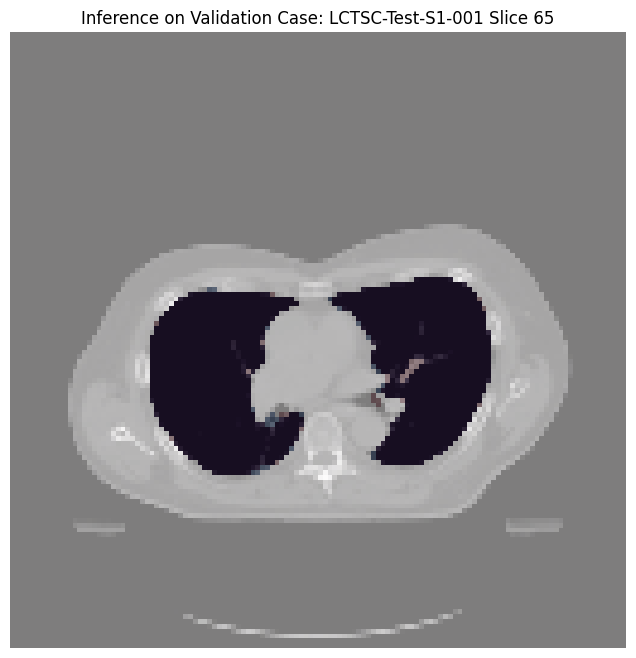

In [ ]:
# Make inference on a validation case
val_case_path = OUTPUT_DIR / 'Test' / 'LCTSC-Test-S1-101.npz'
data = np.load(val_case_path)
image = data['image']
mask_rlung = data['Lung_R']
mask_llung = data['Lung_L']
ground_truth_mask = np.maximum(mask_rlung, mask_llung).astype(np.float32)

# Preprocess image slices
slice_idx = image.shape[2] // 2
input_image = image[:, :, slice_idx]
input_image_tensor = torch.from_numpy(input_image).unsqueeze(0).unsqueeze(0).float().to(device)

model.eval()
with torch.no_grad():
    output = model(input_image_tensor)
    output_sigmoid = torch.sigmoid(output)
    output_mask = (output_sigmoid > 0.5).float().cpu().squeeze().numpy()

# Plot results
plt.figure(figsize=(8, 8))
plt.imshow(input_image, cmap='gray')
plt.imshow(output_mask, cmap='Reds', alpha=0.3)
plt.imshow(ground_truth_mask[:, :, slice_idx], cmap='Blues', alpha=0.3)
plt.title(f"Inference on Validation Case: LCTSC-Test-S1-001 Slice {slice_idx}")
plt.axis('off')
plt.show()

In [ ]:
# Make inference on a hidden test case
image = np.load('hidden_test_set/LUNG1-001/ct.npy')
image = hu_windowing(image, -500, 1000)
slice_idx = image.shape[2] // 2
input_image = image[:, :, slice_idx]
input_image_tensor = torch.from_numpy(input_image).unsqueeze(0).unsqueeze(0).float().to(device)

In [ ]:
def interactive_slice_viewer_hidden_test(dicom_image, model, device):
    """Interactive viewer for browsing through CT scan slices of hidden test case."""
    slices = [dicom_image[:, :, i] for i in range(dicom_image.shape[2])]
    
    def show_slice(slice_num):
        input_image = slices[slice_num]
        input_image_tensor = torch.from_numpy(input_image).unsqueeze(0).unsqueeze(0).float().to(device)

        model.eval()
        with torch.no_grad():
            output = model(input_image_tensor)
            output_sigmoid = torch.sigmoid(output)
            output_mask = (output_sigmoid > 0.5).float().cpu().squeeze().numpy()
        
        # Apply binary erosion to clean up the mask
        from scipy.ndimage import binary_erosion
        output_mask = binary_erosion(output_mask, structure=np.ones((3,3)), iterations=1).astype(output_mask.dtype)

        plt.figure(figsize=(8, 8))
        plt.imshow(input_image, cmap='gray')
        plt.imshow(output_mask, cmap='Reds', alpha=0.3)
        plt.title(f"Slice: {slice_num}")
        plt.axis('off')
        plt.show()

    interact(show_slice, slice_num=IntSlider(min=0, max=len(slices) - 1, step=1, description='Slice Number'))

# Example: Interactive slice viewing for the hidden test case
interactive_slice_viewer_hidden_test(image, model, device)

interactive(children=(IntSlider(value=0, description='Slice Number', max=133), Output()), _dom_classes=('widge…